In [3]:
import pandas as pd
import numpy as np

# データの読み込み
data = pd.read_csv('../data/A_LMPFreq3_Labeled.csv')
lmp_data = data.iloc[:, 2:].values.T
labels = data.iloc[:, 1].values

print(f"データの形状: {lmp_data.shape}")
print(f"ラベルの形状: {labels.shape}")
print(f"データの要約統計量:\n{pd.DataFrame(lmp_data.T).describe()}")
print(f"欠損値の数: {np.isnan(lmp_data).sum()}")
print(f"無限大の数: {np.isinf(lmp_data).sum()}")

# データの一部を表示
print("\nデータの最初の5行:")
print(pd.DataFrame(lmp_data.T).head())
print("\nデータの最後の5行:")
print(pd.DataFrame(lmp_data.T).tail())

データの形状: (140, 8784)
ラベルの形状: (8784,)
データの要約統計量:
               0            1            2            3            4    \
count  8784.000000  8784.000000  8784.000000  8784.000000  8784.000000   
mean     25.641584    25.897573    25.882745    25.854376    26.347040   
std       0.595659     0.582852     0.614153     0.644069     0.791407   
min      23.255167    23.534724    23.454892    23.368142    23.632242   
25%      25.419584    25.705994    25.638815    25.567387    25.910636   
50%      25.860299    26.111388    26.100227    26.076613    26.591415   
75%      25.933984    26.177095    26.177850    26.163442    26.710492   
max      27.461687    27.711786    27.770431    27.806429    28.662581   

               5            6            7            8            9    ...  \
count  8784.000000  8784.000000  8784.000000  8784.000000  8784.000000  ...   
mean     27.133835    27.313923    26.881421    26.698560    27.442546  ...   
std       0.896519     0.885097     1.024974     

In [4]:
import numpy as np

def calculate_qq_distance(v0, v1):
    # 欠損値や無限大を除外
    v0 = v0[np.isfinite(v0)]
    v1 = v1[np.isfinite(v1)]
    
    if len(v0) == 0 or len(v1) == 0:
        return np.nan
    
    s = min(len(v0), len(v1))
    v0_sorted = np.sort(v0)[:s]
    v1_sorted = np.sort(v1)[:s]
    
    qq_distances = np.abs(v1_sorted - v0_sorted)
    
    return np.mean(qq_distances) * np.sqrt(2) / 2

def qq_detection(data, window_size=24, approach=1):
    n_samples, n_channels = data.shape
    detection_statistics = np.zeros((n_samples - window_size + 1, n_channels))
    
    if approach == 1:
        for channel in range(n_channels):
            reference_window = data[:window_size, channel]
            
            for i in range(n_samples - window_size + 1):
                current_window = data[i:i+window_size, channel]
                detection_statistics[i, channel] = calculate_qq_distance(reference_window, current_window)
    
    elif approach == 2:
        for channel in range(n_channels):
            for i in range(1, n_samples - window_size + 1):
                prev_window = data[i-1:i+window_size-1, channel]
                current_window = data[i:i+window_size, channel]
                detection_statistics[i-1, channel] = calculate_qq_distance(prev_window, current_window)
    
    total_detection_statistic = np.nansum(detection_statistics, axis=1)
    
    return total_detection_statistic, detection_statistics

NameError: name 'detect_changes' is not defined

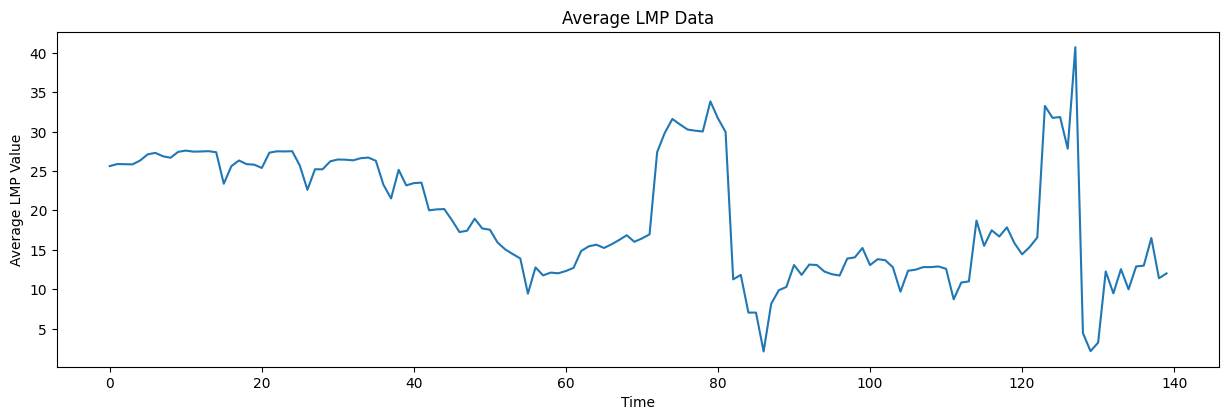

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def analyze_and_visualize(data, labels, window_sizes=[24, 48, 72]):
    plt.figure(figsize=(15, 5 * (len(window_sizes) + 1)))
    
    plt.subplot(len(window_sizes) + 1, 1, 1)
    plt.plot(data.mean(axis=1))  # チャンネルの平均をプロット
    plt.title('Average LMP Data')
    plt.xlabel('Time')
    plt.ylabel('Average LMP Value')
    
    true_changes = np.where(np.diff(labels) != 0)[0]
    
    for i, window_size in enumerate(window_sizes):
        # データの平滑化
        smoothed_data = savgol_filter(data, window_length=window_size, polyorder=3, axis=0)
        
        stats1, _ = qq_detection(smoothed_data, window_size, approach=1)
        stats2, _ = qq_detection(smoothed_data, window_size, approach=2)
        
        # NaNを0に置換
        stats1 = np.nan_to_num(stats1, nan=0.0)
        stats2 = np.nan_to_num(stats2, nan=0.0)
        
        # 変化点の検出
        detected_changes1 = detect_changes(stats1)
        detected_changes2 = detect_changes(stats2)
        
        plt.subplot(len(window_sizes) + 1, 1, i + 2)
        plt.plot(stats1, label='Approach 1')
        plt.plot(stats2, label='Approach 2')
        plt.title(f'QQ Distance Statistics (Window Size: {window_size})')
        plt.xlabel('Time')
        plt.ylabel('QQ Distance')
        plt.legend()
        
        # 真の変化点と検出された変化点をプロット
        plt.vlines(true_changes, plt.ylim()[0], plt.ylim()[1], colors='r', linestyles='dashed', label='True Changes')
        plt.vlines(detected_changes1, plt.ylim()[0], plt.ylim()[1], colors='g', linestyles='dotted', label='Detected (Approach 1)')
        plt.vlines(detected_changes2, plt.ylim()[0], plt.ylim()[1], colors='b', linestyles='dotted', label='Detected (Approach 2)')
        plt.legend()
        
        # 評価指標の計算と表示
        precision1, recall1, f1_1 = calculate_metrics(detected_changes1, true_changes)
        precision2, recall2, f1_2 = calculate_metrics(detected_changes2, true_changes)
        
        print(f"\nWindow Size: {window_size}")
        print("Approach 1 metrics:")
        print(f"Precision: {precision1:.4f}")
        print(f"Recall: {recall1:.4f}")
        print(f"F1 Score: {f1_1:.4f}")
        
        print("\nApproach 2 metrics:")
        print(f"Precision: {precision2:.4f}")
        print(f"Recall: {recall2:.4f}")
        print(f"F1 Score: {f1_2:.4f}")
    
    plt.tight_layout()
    plt.show()

# メイン実行部分
data = pd.read_csv('../data/A_LMPFreq3_Labeled.csv')
lmp_data = data.iloc[:, 2:].values.T
labels = data.iloc[:, 1].values

analyze_and_visualize(lmp_data, labels)